### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import os, sys
import random
from pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

rcParams['figure.figsize'] = 18, 8


if not sys.warnoptions:
    import warnings
    warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
pd.set_option('max_colwidth', 400)

/home/adeptschneiderthedev/.miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#-----------------------Imports from Sktime-------------------------
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter, 
    ForecastingGridSearchCV
)
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

### Set seed for reproducibility

In [3]:
def set_seed(seed=4242):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
set_seed()

In [4]:
train_df = pd.read_csv('Train.csv', parse_dates=['date'])
sample_submission_df = pd.read_csv('SampleSubmission.csv')
segregated_df = pd.read_csv('segregated_df.csv')

In [5]:
train_df.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0


In [6]:
train_df.tail()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
289921,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,12.035682,0.0,NaN,NaN,NaN
289922,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,15.711023,0.0,NaN,NaN,NaN
289923,NaN,NaN,NaN,NaN,NaN,NaN,ID_65a7bf329fa4627faf28390c,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,15.464425,0.0,NaN,NaN,NaN
289924,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,10.016481,0.0,NaN,NaN,NaN
289925,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,9.990000,0.0,NaN,NaN,NaN


In [7]:
# Add a column for the week
train_df['date'] = pd.to_datetime(train_df['date'])

In [8]:
def week_of_month(date_val):
    first_day = date_val.replace(day=1)
    day_of_month = date_val.day
    adjusted_dom = day_of_month + first_day.weekday()
    return int(np.ceil(adjusted_dom/7))

In [9]:
train_df['day'] = train_df['date'].dt.day
train_df['year'] = train_df['date'].dt.year  # Day of the month 
train_df['week'] = train_df['date'].dt.isocalendar().week  # Week of the year
train_df['month'] = train_df['date'].dt.month  # Month of the year
train_df['is_weekend'] = train_df['date'].dt.dayofweek >= 5  # True for Sat/Sun
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['week_of_month'] = train_df['date'].apply(week_of_month)
train_df['is_month_start'] = train_df.date.dt.is_month_start.astype(int)
train_df['is_month_end'] = train_df.date.dt.is_month_end.astype(int)
train_df['quarter_of_year'] = train_df.date.dt.quarter
train_df['day_of_year'] = train_df.date.dt.dayofyear

In [10]:
train_df.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,day,year,week,month,is_weekend,day_of_week,week_of_month,is_month_start,is_month_end,quarter_of_year,day_of_year
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0,1,2020,1,1,False,2,1,1,0,1,1
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0,1,2020,1,1,False,2,1,1,0,1,1
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0,1,2020,1,1,False,2,1,1,0,1,1
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0,1,2020,1,1,False,2,1,1,0,1,1
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0,1,2020,1,1,False,2,1,1,0,1,1


In [11]:
train_df.tail()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,day,year,week,month,is_weekend,day_of_week,week_of_month,is_month_start,is_month_end,quarter_of_year,day_of_year
289921,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,12.035682,0.0,NaN,NaN,NaN,3,2024,5,2,True,5,1,0,0,1,34
289922,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,15.711023,0.0,NaN,NaN,NaN,4,2024,5,2,True,6,1,0,0,1,35
289923,NaN,NaN,NaN,NaN,NaN,NaN,ID_65a7bf329fa4627faf28390c,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,15.464425,0.0,NaN,NaN,NaN,3,2024,5,2,True,5,1,0,0,1,34
289924,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,10.016481,0.0,NaN,NaN,NaN,3,2024,5,2,True,5,1,0,0,1,34
289925,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,9.990000,0.0,NaN,NaN,NaN,4,2024,5,2,True,6,1,0,0,1,35


In [12]:
train_df.isnull().sum()

impressions              400
clicks                   400
cost                     400
conversions              400
ad_type                  400
currency                 400
ID                         0
date                       0
call_type             253026
call_status           253026
start_time            253026
duration              253026
end_time              253026
display_location      253026
impression_share           0
conversions_calls       9855
headline1_len            400
headline2_len            400
ad_description_len       400
day                        0
year                       0
week                       0
month                      0
is_weekend                 0
day_of_week                0
week_of_month              0
is_month_start             0
is_month_end               0
quarter_of_year            0
day_of_year                0
dtype: int64

In [13]:
def remove_nans(data, thresh):
    def nans_rate(data, col):
        return data[col].isna().sum() / data.shape[0]
    
    for col in data.columns:
        if nans_rate(data, col) >= thresh:
            data.drop(col, axis=1, inplace=True)
            
    return data

train = remove_nans(train_df, 0.7)
train.shape

(289926, 24)

In [14]:
train.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,day,year,week,month,is_weekend,day_of_week,week_of_month,is_month_start,is_month_end,quarter_of_year,day_of_year
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,5.0,11.0,1,2020,1,1,False,2,1,1,0,1,1
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,13.0,1,2020,1,1,False,2,1,1,0,1,1
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,10.0,1,2020,1,1,False,2,1,1,0,1,1
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,3.0,13.0,1,2020,1,1,False,2,1,1,0,1,1
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,13.0,1,2020,1,1,False,2,1,1,0,1,1


### Aggregate the data by ID

In [11]:
train_df_grouped = train_df.groupby(['date', 'ID']).sum()
train_df_grouped = train_df_grouped.reset_index()

In [12]:
train_df_grouped.isnull().sum()

date                  0
ID                    0
impressions           0
clicks                0
cost                  0
conversions           0
ad_type               0
currency              0
call_type             0
call_status           0
start_time            0
duration              0
end_time              0
display_location      0
impression_share      0
conversions_calls     0
headline1_len         0
headline2_len         0
ad_description_len    0
dtype: int64

In [13]:
train_df_grouped.head()

,date,ID,impressions,clicks,cost,conversions,ad_type,currency,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,2020-01-01,ID_5da86e71bf5dee4cf5047046,393.0,36.0,8087.0,0.0,EXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_AD,ZARZARZARZARZARZAR,0,0,0,0.0,0,0,97.678015,0.0,12.0,18.0,70.0
1,2020-01-02,ID_5da86e71bf5dee4cf5047046,395.0,50.0,9831.0,0.0,EXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_AD,ZARZARZARZARZARZAR,0,0,0,0.0,0,0,97.362532,0.0,12.0,18.0,70.0
2,2020-01-03,ID_5da86e71bf5dee4cf5047046,404.0,54.0,9774.0,0.0,EXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_AD,ZARZARZARZARZARZAR,0,0,0,0.0,0,0,125.369703,0.0,12.0,18.0,70.0
3,2020-01-04,ID_5da86e71bf5dee4cf5047046,476.0,47.0,8217.0,0.0,EXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_AD,ZARZARZARZARZARZAR,0,0,0,0.0,0,0,126.616261,0.0,12.0,18.0,70.0
4,2020-01-05,ID_5da86e71bf5dee4cf5047046,466.0,59.0,10806.0,0.0,EXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_ADEXPANDED_TEXT_AD,ZARZARZARZARZARZAR,0,0,0,0.0,0,0,143.848584,0.0,12.0,18.0,70.0


In [14]:
train_df_grouped.tail()

,date,ID,impressions,clicks,cost,conversions,ad_type,currency,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
67963,2024-02-13,ID_65660b0c15962a6be05ec935,30.0,6.0,7666.0,0.0,RESPONSIVE_SEARCH_ADEXPANDED_DYNAMIC_SEARCH_AD,ZARZAR,0,0,0,0.0,0,0,85.487179,0.0,5.0,4.0,11.0
67964,2024-02-13,ID_656747739b5c72023947f7c7,47.0,7.0,5925.0,0.0,RESPONSIVE_SEARCH_AD,ZAR,0,0,0,0.0,0,0,10.264195,0.0,3.0,3.0,12.0
67965,2024-02-13,ID_65687e2b40ea026fcc662a75,100.0,7.0,8231.0,0.0,RESPONSIVE_SEARCH_ADRESPONSIVE_SEARCH_ADRESPONSIVE_SEARCH_AD,ZARZARZAR,0,0,0,0.0,0,0,63.588410,0.0,10.0,16.0,37.0
67966,2024-02-13,ID_65a7bf329fa4627faf28390c,165.0,17.0,522.0,0.0,EXPANDED_DYNAMIC_SEARCH_ADRESPONSIVE_SEARCH_ADRESPONSIVE_SEARCH_AD,USDUSDUSD,0,0,0,0.0,0,0,42.723828,0.0,3.0,9.0,28.0
67967,2024-02-13,ID_65b0f65c7fe62e56c5593d55,1108.0,74.0,17993.0,0.0,RESPONSIVE_SEARCH_ADRESPONSIVE_SEARCH_ADRESPONSIVE_SEARCH_ADEXPANDED_DYNAMIC_SEARCH_ADRESPONSIVE_SEARCH_AD,ZARZARZARZARZAR,0,0,0,0.0,0,0,49.950000,0.0,4.0,17.0,56.0


### Visualize Data on a Time Plot

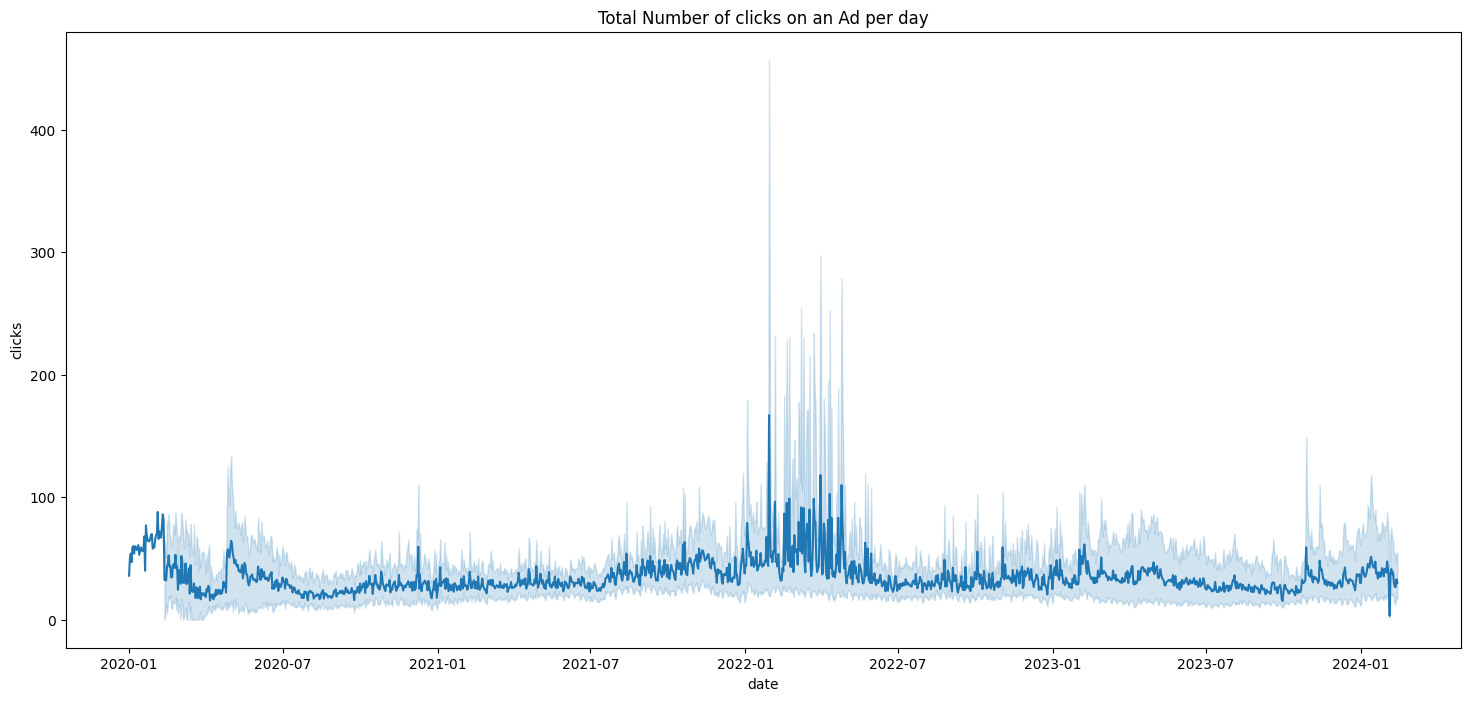

In [72]:
sns.lineplot(data=train_df_grouped, x='date', y='clicks')
plt.title('Total Number of clicks on an Ad per day')
plt.show()

In [15]:
# Get numerical columns
numerical_cols = train_df_grouped.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols

['impressions',
 'clicks',
 'cost',
 'conversions',
 'duration',
 'impression_share',
 'conversions_calls',
 'headline1_len',
 'headline2_len',
 'ad_description_len']

In [16]:
train_numerical_df = train_df_grouped[numerical_cols]

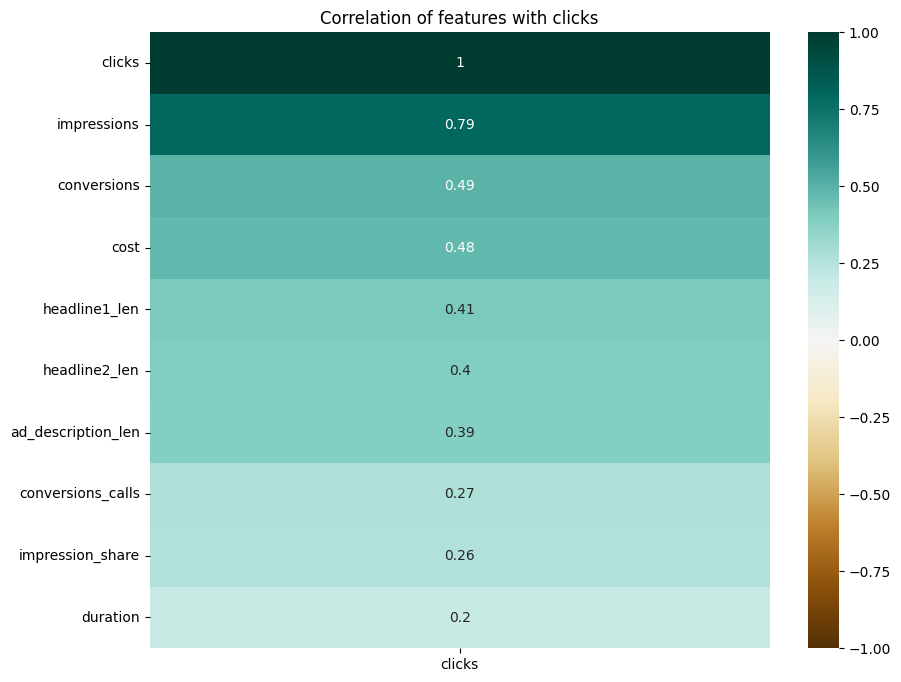

In [17]:
correlation = train_numerical_df.corr()

# Plot the correlation of 'clicks' with other features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation[['clicks']].sort_values(by='clicks', ascending=False), 
            vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation of features with clicks')
plt.show()

In [18]:
segregated_df.head()

,ID,clicks,date
0,ID_5da86e71bf5dee4cf5047046,0,2024-01-22
1,ID_5da86e71bf5dee4cf5047046,0,2024-01-29
2,ID_5e43c29e6279884e2827d894,0,2024-02-21
3,ID_5e43c29e6279884e2827d894,0,2024-02-28
4,ID_5e4e7b480e374330ee151305,0,2023-12-04


In [19]:
segregated_df.tail()

,ID,clicks,date
365,ID_6568807cbb9c4d235c5dd9a8,0,2024-02-06
366,ID_65a7bf329fa4627faf28390c,0,2024-02-21
367,ID_65a7bf329fa4627faf28390c,0,2024-02-28
368,ID_65b0f65c7fe62e56c5593d55,0,2024-02-21
369,ID_65b0f65c7fe62e56c5593d55,0,2024-02-28


In [20]:
sample_submission_df.head()

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,338.533386
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,340.315948
2,ID_5e43c29e6279884e2827d894_2024_02_21,338.533356
3,ID_5e43c29e6279884e2827d894_2024_02_28,340.315887
4,ID_5e4e7b480e374330ee151305_2023_12_04,0.000000


In [21]:
sample_submission_df.tail()

,ID,clicks
365,ID_6568807cbb9c4d235c5dd9a8_2024_02_06,0.0
366,ID_65a7bf329fa4627faf28390c_2024_02_21,0.0
367,ID_65a7bf329fa4627faf28390c_2024_02_28,0.0
368,ID_65b0f65c7fe62e56c5593d55_2024_02_21,0.0
369,ID_65b0f65c7fe62e56c5593d55_2024_02_28,0.0


In [22]:
sample_submission_df.shape

(370, 2)

In [23]:
print(len(segregated_df['ID'].unique()))

185


In [24]:
unique_ids = segregated_df['ID'].unique()

### LightGBM Helper Functions

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

regressor = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, num_leaves=64, n_jobs=-1)

param_grid = {
    "window_length": [5, 10, 15, 20, 25, 30] # parameter set to be grid searched
}


def timeseries_split_forecast(df, dates):
    trainseries = df.copy()
    trainseries = trainseries.drop(['currency', 'ad_type', 'call_type', 'display_location', 'call_status', 'duration', 'start_time', 'end_time' ], axis=1)
    trainseries['ID'] = le.fit_transform(trainseries['ID'])
    trainseries = trainseries.set_index(['date'])
    trainseries.index.freq = pd.infer_freq(trainseries.index)
    fh = ForecastingHorizon(
        values=dates,
        is_relative=False
    )
    X = trainseries.drop('clicks', axis=1)
    y = trainseries['clicks']
    y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)
    forecaster = make_reduction(regressor, window_length=13, strategy='recursive', scitype="tabular-regressor")
    # Grid search on window_length
    # cv = ExpandingWindowSplitter()
    # gscv = ForecastingGridSearchCV(
    #     forecaster, strategy="refit", cv=cv, param_grid=param_grid, 
    #     scoring=MeanAbsolutePercentageError(symmetric=True)
    # )
    forecaster.fit(y_train, X_train)
    y_pred = forecaster.predict(fh)
    return y_pred

### Naive forecasting using median values of the individual ID time series as the forecast

- It achieves a Root Mean Squared Error (RMSE) of 14.59030906
- Run this to ran the naive forecasting implementation. We tried different naive forecasting techniques such as mean, median, and mode. The median value of the individual ID time series was the best performing naive forecasting technique. This is the current implementation that works.

In [95]:
# Iterate over unique IDs
for i in unique_ids:
    # Get the data for the current ID from train_df_grouped
    id_data = train_df_grouped[train_df_grouped['ID'] == i]
    
    # Calculate the mean of the clicks column
    mean_clicks = id_data['clicks'].median()
    
    # Update all rows in segregated_df with the current ID
    segregated_df.loc[segregated_df['ID'] == i, 'clicks'] = mean_clicks

### Multivariate Time Series Forecasting using LightGBM

- This implementation uses LightGBM to forecast the target variable. It gave the best submission but the index frequency error just keeps popping up. We tried to fix it but couldn't. We are still working on it.

In [26]:
# Iterate over unique IDs
for i in unique_ids:
    # Get the data for the current ID from train_df_grouped
    id_data = train_df_grouped[train_df_grouped['ID'] == i]

    # Get the future dates for the current ID from segregated_df
    id_segregated_df = segregated_df[segregated_df['ID'] == i]

    future_dates = id_segregated_df['date']

    # dates = [future_dates[0], future_dates[1]]
    dates = pd.DatetimeIndex([future_dates[0], future_dates[1]])
    
    y_pred = timeseries_split_forecast(id_data, dates)
    
    # Update all rows in segregated_df with the current ID
    segregated_df.loc[segregated_df['ID'] == i, 'clicks'] = y_pred[1]

### Prepare submission file

In [101]:
segregated_df.tail()

,ID,clicks,date
365,ID_6568807cbb9c4d235c5dd9a8,4.239130,2024-02-06
366,ID_65a7bf329fa4627faf28390c,16.391304,2024-02-21
367,ID_65a7bf329fa4627faf28390c,16.391304,2024-02-28
368,ID_65b0f65c7fe62e56c5593d55,56.952381,2024-02-21
369,ID_65b0f65c7fe62e56c5593d55,56.952381,2024-02-28


In [21]:
segregated_df_copy = segregated_df.copy()

In [22]:
segregated_df_copy['date'] = pd.to_datetime(segregated_df_copy['date'])

In [23]:
segregated_df_copy['ID'] = segregated_df_copy['ID'] + '_' + segregated_df_copy['date'].dt.strftime('%Y_%m_%d')

In [24]:
segregated_df_copy.head()

,ID,clicks,date
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,79.824813,2024-01-22
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,79.824813,2024-01-29
2,ID_5e43c29e6279884e2827d894_2024_02_21,7.765759,2024-02-21
3,ID_5e43c29e6279884e2827d894_2024_02_28,7.765759,2024-02-28
4,ID_5e4e7b480e374330ee151305_2023_12_04,8.269085,2023-12-04


In [25]:
segregated_df_copy.tail()

,ID,clicks,date
365,ID_6568807cbb9c4d235c5dd9a8_2024_02_06,4.239130,2024-02-06
366,ID_65a7bf329fa4627faf28390c_2024_02_21,16.391304,2024-02-21
367,ID_65a7bf329fa4627faf28390c_2024_02_28,16.391304,2024-02-28
368,ID_65b0f65c7fe62e56c5593d55_2024_02_21,56.952381,2024-02-21
369,ID_65b0f65c7fe62e56c5593d55_2024_02_28,56.952381,2024-02-28


In [26]:
segregated_df['clicks'] = segregated_df['clicks'].round()

In [27]:
segregated_df.head()

,ID,clicks,date
0,ID_5da86e71bf5dee4cf5047046,80.0,2024-01-22
1,ID_5da86e71bf5dee4cf5047046,80.0,2024-01-29
2,ID_5e43c29e6279884e2827d894,8.0,2024-02-21
3,ID_5e43c29e6279884e2827d894,8.0,2024-02-28
4,ID_5e4e7b480e374330ee151305,8.0,2023-12-04


In [29]:
segregated_df.tail()

,ID,clicks,date
365,ID_6568807cbb9c4d235c5dd9a8,4.0,2024-02-06
366,ID_65a7bf329fa4627faf28390c,16.0,2024-02-21
367,ID_65a7bf329fa4627faf28390c,16.0,2024-02-28
368,ID_65b0f65c7fe62e56c5593d55,57.0,2024-02-21
369,ID_65b0f65c7fe62e56c5593d55,57.0,2024-02-28


In [30]:
segregated_df_copy.drop('date', axis=1, inplace=True)

In [31]:
segregated_df_copy.head()

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,79.824813
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,79.824813
2,ID_5e43c29e6279884e2827d894_2024_02_21,7.765759
3,ID_5e43c29e6279884e2827d894_2024_02_28,7.765759
4,ID_5e4e7b480e374330ee151305_2023_12_04,8.269085


In [32]:
segregated_df_copy.tail()

,ID,clicks
365,ID_6568807cbb9c4d235c5dd9a8_2024_02_06,4.239130
366,ID_65a7bf329fa4627faf28390c_2024_02_21,16.391304
367,ID_65a7bf329fa4627faf28390c_2024_02_28,16.391304
368,ID_65b0f65c7fe62e56c5593d55_2024_02_21,56.952381
369,ID_65b0f65c7fe62e56c5593d55_2024_02_28,56.952381


In [33]:
segregated_df_copy.shape

(370, 2)

In [34]:
segregated_df_copy.to_csv('submission.csv', index=False)